In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
from copy import deepcopy
import pickle
import seaborn as sns
import pandas as pd
from masking import centre_mask, non_centre_mask, random_mask
import traceback

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

### Define variables

In [2]:


IMG_SIZE = 224
FOLDER_PATH = "Images/100"

masks = {
    "Centre": centre_mask,
    "Non-centre": non_centre_mask,
    "Random": random_mask 
}

classification_models = ["CNN", "KNN", "SVM", "Random Forest"]

models_masks_accuracies = {model: {mask: -1 for mask in masks.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_masks_f1_scores = {model: {mask: -1 for mask in masks.keys()}  # -1 represent not yet calculated
                               for model in classification_models}
models_masks_confusion_metrics = {model: {mask: -1 for mask in masks.keys()}  # -1 represent not yet calculated
                               for model in classification_models}

def build_transform(mask: str) -> transforms.Compose:
    mask = masks.get(mask)

    return transforms.Compose([
        transforms.Lambda(mask),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

### Define Image Dataset structure and image transform

In [3]:
class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)
    

labels = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))



masking_datasets = {key : ImageDataSet(image_names, build_transform(key)) for key in masks.keys()}

### CNN models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_names))
model = model.to(device)

masking_cnn_models = {key : deepcopy(model).to(device) for key in masks.keys()}

c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# hyper-parameters setting
num_epochs = 100
patience = 10 #for early stopping
batch_size = 128
learning_rate = 0.001

In [6]:
def split_dataset(dataset: ImageDataSet):
    train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=0)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

### CNN Model training

In [7]:
training_loss_curves = {key : [] for key in masks.keys()}
val_loss_curves = {key : [] for key in masks.keys()}

for mask, model in masking_cnn_models.items():
    print(f"Start training {mask} model.")
    best_val_loss = float('inf')
    epoch_no_improvement = 0
    best_model_parameters = None
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, _ = split_dataset(masking_datasets.get(mask))
    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            training_loss = running_loss/len(train_loader)
            training_loss_curves[mask].append(training_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss:.4f}")
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            avg_val_loss = val_loss/len(val_loader)
            val_accuracy = 100 * correct / total
            print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
            val_loss_curves[mask].append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_parameters = model.state_dict()
                epoch_no_improvement = 0
            else:
                epoch_no_improvement += 1
                if epoch_no_improvement == patience:
                    print(f"No improvement for {patience} epoches. Early stopping.")
                    break

        if best_model_parameters is not None:
            model.load_state_dict(best_model_parameters)
    except Exception as e:
        traceback.print_exc()

Start training Centre model.
Epoch [1/100], Loss: 0.4112
Validation Loss: 0.8500, Accuracy: 70.72%
Epoch [2/100], Loss: 0.2886
Validation Loss: 0.7319, Accuracy: 73.43%
Epoch [3/100], Loss: 0.2440
Validation Loss: 0.5290, Accuracy: 76.15%
Epoch [4/100], Loss: 0.2091
Validation Loss: 0.6382, Accuracy: 70.01%
Epoch [5/100], Loss: 0.1816
Validation Loss: 0.6777, Accuracy: 83.92%
Epoch [6/100], Loss: 0.1601
Validation Loss: 1.7195, Accuracy: 73.24%
Epoch [7/100], Loss: 0.1389
Validation Loss: 1.0708, Accuracy: 78.39%
Epoch [8/100], Loss: 0.1224
Validation Loss: 1.1062, Accuracy: 66.17%
Epoch [9/100], Loss: 0.1021
Validation Loss: 1.7653, Accuracy: 57.50%
Epoch [10/100], Loss: 0.0815
Validation Loss: 0.9261, Accuracy: 77.98%
Epoch [11/100], Loss: 0.0711
Validation Loss: 0.4988, Accuracy: 88.11%
Epoch [12/100], Loss: 0.0574
Validation Loss: 1.2692, Accuracy: 73.64%
Epoch [13/100], Loss: 0.0538
Validation Loss: 0.4538, Accuracy: 90.19%
Epoch [14/100], Loss: 0.0432
Validation Loss: 0.5151, Acc

In [8]:
for mask, model in masking_cnn_models.items():
    torch.save(model.state_dict(), f'masking_models/CNN_{mask}.pth')

### CNN models evaluation

In [10]:
for mask, model in masking_cnn_models.items():
    _, _, test_loader = split_dataset(masking_datasets.get(mask))
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    models_masks_accuracies["CNN"][mask] = accuracy
    models_masks_f1_scores["CNN"][mask] = f1
    models_masks_confusion_metrics["CNN"][mask] = cm
    
    print(f"{mask} accuracy: {accuracy}")
    print(f"{mask} f1 score: {f1}")

Centre accuracy: 0.8804024496937882
Centre f1 score: 0.8803434754227841
Non-centre accuracy: 0.742257217847769
Non-centre f1 score: 0.7326750088808978
Random accuracy: 0.9042869641294838
Random f1 score: 0.9039234357039575


In [11]:
def datasets_feature_extractor(model, dataset):
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1]) # remove the last layer
    feature_extractor.eval()
    feature_extractor.to(device)

    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    train_loader, _, test_loader = split_dataset(dataset)

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            train_features.append(output.cpu().numpy())
            train_labels.append(labels.cpu().numpy())

    X_train = np.vstack(train_features)
    y_train = np.hstack(train_labels)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            output = feature_extractor(images).squeeze()
            test_features.append(output.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    X_test = np.vstack(test_features)
    y_test = np.hstack(test_labels)

    return X_train, y_train, X_test, y_test

In [13]:
for mask, dataset in masking_datasets.items():
    X_train, y_train, X_test, y_test = datasets_feature_extractor(model, dataset)

    # SVM
    svm = SVC()
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    models_masks_accuracies["SVM"][mask] = accuracy
    models_masks_f1_scores["SVM"][mask] = f1
    models_masks_confusion_metrics["SVM"][mask] = cm

    print(f"SVM {mask} accuracy: {accuracy}")
    print(f"SVM {mask} f1 score: {f1}")

    #RF
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    models_masks_accuracies["Random Forest"][mask] = accuracy
    models_masks_f1_scores["Random Forest"][mask] = f1
    models_masks_confusion_metrics["Random Forest"][mask] = cm

    print(f"Random Forest {mask} accuracy: {accuracy}")
    print(f"Random Forest {mask} f1 score: {f1}")

    #Find best k for KNN
    knn_models = []
    knn_accuracies = []
    knn_f1_scores = []
    knn_confusion_metrics = []
    for k in range(1, 32, 2): #k = 1 to 31
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        knn_models.append(knn)
        knn_accuracies.append(accuracy)
        knn_f1_scores.append(f1)
        knn_confusion_metrics.append(cm)

    knn_accuracies = np.array(knn_accuracies)
    max_idx = np.argmax(knn_accuracies)
    best_k = 2*max_idx+1

    print(f"Best {best_k}NN {mask} accuracy: {knn_accuracies[max_idx]}")
    print(f"Best {best_k}NN {mask} f1 score: {knn_f1_scores[max_idx]}")

    accuracy = float(knn_accuracies[max_idx])
    f1 = knn_f1_scores[max_idx]
    cm = knn_confusion_metrics[max_idx]

    models_masks_accuracies["KNN"][mask] = accuracy
    models_masks_f1_scores["KNN"][mask] = f1
    models_masks_confusion_metrics["KNN"][mask] = cm

    with open(f"masking_models/SVM_{mask}.pkl", "wb") as f:
        pickle.dump(svm, f)
    with open(f"masking_models/RF_{mask}.pkl", "wb") as f:
        pickle.dump(rf, f)
    with open(f"masking_models/{best_k}NN_{mask}.pkl", "wb") as f:
        pickle.dump(knn_models[max_idx], f)

SVM Centre accuracy: 0.8713035870516186
SVM Centre f1 score: 0.871493018529097
Random Forest Centre accuracy: 0.873928258967629
Random Forest Centre f1 score: 0.8739201187243083
Best 25NN Centre accuracy: 0.8664041994750656
Best 25NN Centre f1 score: 0.8663583566867673
SVM Non-centre accuracy: 0.9100612423447069
SVM Non-centre f1 score: 0.9101676269740689
Random Forest Non-centre accuracy: 0.9072615923009624
Random Forest Non-centre f1 score: 0.9073102901179058
Best 29NN Non-centre accuracy: 0.9073490813648294
Best 29NN Non-centre f1 score: 0.9073862497910097
SVM Random accuracy: 0.9144356955380577
SVM Random f1 score: 0.9144221278294676
Random Forest Random accuracy: 0.9146981627296588
Random Forest Random f1 score: 0.9147239338059465
Best 9NN Random accuracy: 0.915573053368329
Best 9NN Random f1 score: 0.9156038171152967


In [14]:
with open("masking_variables/models_masks_accuracies.pkl", 'wb') as f:
    pickle.dump(models_masks_accuracies, f)
with open("masking_variables/models_masks_f1_scores.pkl", 'wb') as f:
    pickle.dump(models_masks_f1_scores, f)
with open("masking_variables/models_masks_confusion_metrics.pkl", 'wb') as f:
    pickle.dump(models_masks_confusion_metrics, f)
with open("masking_variables/training_loss_curves.pkl", 'wb') as f:
    pickle.dump(training_loss_curves, f)
with open("masking_variables/val_loss_curves.pkl", 'wb') as f:
    pickle.dump(val_loss_curves, f)

## Visualisation

### Accuracy

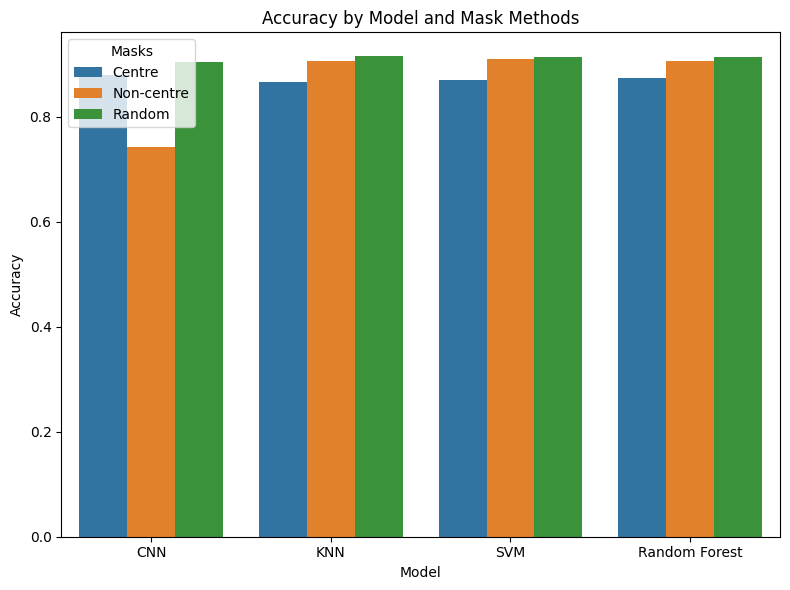

In [15]:
df = pd.DataFrame(models_masks_accuracies).T.reset_index().melt(id_vars='index', var_name='Mask', value_name='Accuracy')
df.columns = ['Model', 'Mask', 'Accuracy']
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='Accuracy', hue='Mask')

plt.title('Accuracy by Model and Mask Methods')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Masks')
plt.tight_layout()
plt.show()

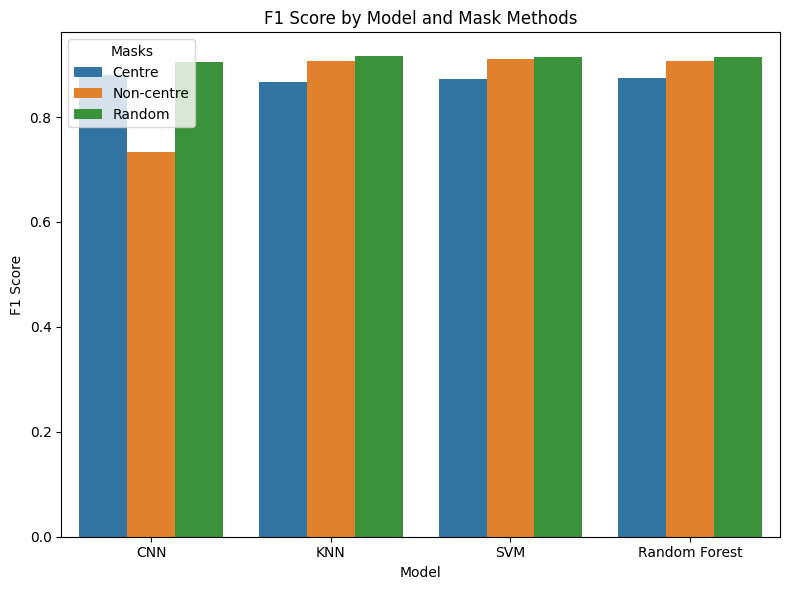

In [16]:
df = pd.DataFrame(models_masks_f1_scores).T.reset_index().melt(id_vars='index', var_name='Mask', value_name='F1 Score')
df.columns = ['Model', 'Mask', 'F1 Score']
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='F1 Score', hue='Mask')

plt.title('F1 Score by Model and Mask Methods')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.legend(title='Masks')
plt.tight_layout()
plt.show()

### Validation Loss Curve

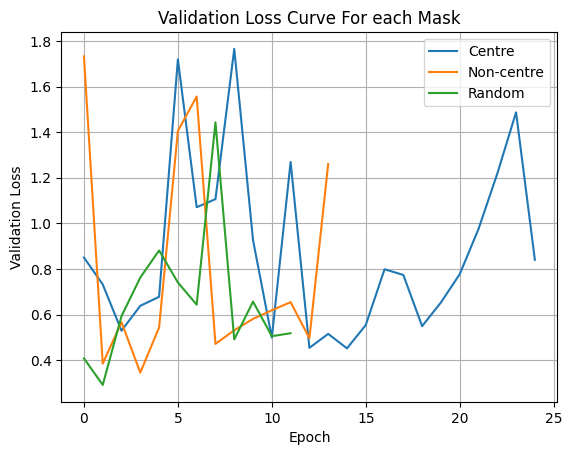

In [19]:
plt.figure()
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in val_loss_curves.items()]))
# for mask, val_losses in val_loss_curves.items():
#     plt.plot(val_losses, label=mask)
# df = pd.DataFrame(val_loss_curves)
for mask in df.columns:
    plt.plot(df[mask], label=mask)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curve For each Mask')
plt.legend()
plt.grid(True)
plt.show()